### Conformalized quantile regression(CQR)

The link to the original paper
http://papers.neurips.cc/paper/8613-conformalized-quantile-regression.pdf

We use the package in the following link for experiment

https://github.com/yromano/cqr

Note that we use this CQR for median, calibration, and 90% interval only. 

We use the model under the random forest specification with symmetric interval and recommended hyperparameter from the package example

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
np.warnings.filterwarnings('ignore')

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.cp import IcpRegressor
from nonconformist.nc import QuantileRegErrFunc

%matplotlib inline

### load data

In [4]:
np.random.seed(2020)

# generate mu, gaussian
mu=np.random.normal(scale=2,size=1000)

# generate sd, uniform
sig=np.random.uniform(0.5,2.5,size=1000)

# the full design matrix
x=np.c_[mu,sig]

y=np.random.normal(loc=mu,scale=sig,size=(1000,1))


train_x=x[:700,:]
train_y=y[:700].ravel()

test_x=x[700:,:]
test_y=y[700:].ravel()

# compute input dimensions
n_train=len(train_x)
n_test=len(test_x)
in_shape = train_x.shape[1]

# display basic information
print("Dimensions: train set (n=%d, p=%d) ; test set (n=%d, p=%d)" % 
      (train_x.shape[0], train_x.shape[1], test_x.shape[0], test_x.shape[1]))



# divide the data into proper training set and calibration set
idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train/2))
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

Dimensions: train set (n=700, p=2) ; test set (n=300, p=2)


### hyperparameter

In [3]:
#########################################################
# Quantile random forests parameters
# (See QuantileForestRegressorAdapter class in helper.py)
#########################################################

# the number of trees in the forest
n_estimators = 1000

# the minimum number of samples required to be at a leaf node
# (default skgarden's parameter)
min_samples_leaf = 1

# the number of features to consider when looking for the best split
# (default skgarden's parameter)
max_features = train_x.shape[1]


# use cross-validation to tune the quantile levels?
cv_qforest = True

# when tuning the two QRF quantile levels one may
# ask for a prediction band with smaller average coverage
# to avoid too conservative estimation of the prediction band
# This would be equal to coverage_factor*(quantiles[1] - quantiles[0])
coverage_factor = 0.85

# ratio of held-out data, used in cross-validation
cv_test_ratio = 0.05

# seed for splitting the data in cross-validation.
# Also used as the seed in quantile random forests function
cv_random_state = 1

# determines the lowest and highest quantile level parameters.
# This is used when tuning the quanitle levels by cross-validation.
# The smallest value is equal to quantiles[0] - range_vals.
# Similarly, the largest value is equal to quantiles[1] + range_vals.
cv_range_vals = 30

# sweep over a grid of length num_vals when tuning QRF's quantile parameters                   
cv_num_vals = 10


# define the QRF's parameters 
params_qforest = dict()
params_qforest["n_estimators"] = n_estimators
params_qforest["min_samples_leaf"] = min_samples_leaf
params_qforest["max_features"] = max_features
params_qforest["CV"] = cv_qforest
params_qforest["coverage_factor"] = coverage_factor
params_qforest["test_ratio"] = cv_test_ratio
params_qforest["random_state"] = cv_random_state
params_qforest["range_vals"] = cv_range_vals
params_qforest["num_vals"] = cv_num_vals

### CQR model that return the lower and upper conditional quantile

In [32]:
def cqr_lu(level):
    
    # desired quanitile levels
    quantiles = [0.5-level/2, 0.5+level/2]
    # target quantile levels
    quantiles_forest = [quantiles[0]*100, quantiles[1]*100]

    # desired miscoverage error
    alpha = 1-level


    # define QRF model
    quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles_forest,
                                                           params=params_qforest)
        
    # define the CQR object
    nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

    # run CQR procedure
    y_lower, y_upper = helper.run_icp(nc, train_x, train_y, test_x, idx_train, idx_cal, alpha)

    return y_lower,y_upper

#### calibration

In [33]:
per=np.linspace(0.02,0.98,8)

In [35]:
#generate confidence interval estimated mean and std
cqrc=[]

per=np.linspace(0.02,0.98,8)
for i in per:
    lquantile,rquantile=cqr_lu(i)
    cqrc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))


In [36]:
cqrc,np.abs(cqrc-per).mean()

([0.013333333333333334,
  0.15333333333333332,
  0.2833333333333333,
  0.4066666666666667,
  0.6033333333333334,
  0.7466666666666667,
  0.8933333333333333,
  0.99],
 0.022797619047619046)

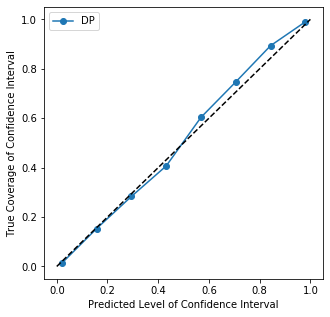

In [41]:
plt.plot(per,cqrc,'o-',label='DP')
plt.xlabel('Predicted Level of Confidence Interval')
plt.ylabel('True Coverage of Confidence Interval')
plt.legend()
plt.plot([0,1],[0,1],'k--')
fig = plt.gcf()
fig.set_size_inches(5,5)

#### 90% CI

In [37]:
lquantile,rquantile=cqr_lu(0.9)
(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

0.9466666666666667

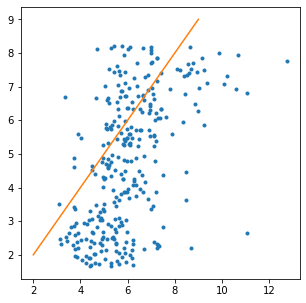

In [39]:
plt.figure(figsize=(5,5))
plt.plot(rquantile-lquantile,test_x[:,1]*3.28,'.')
plt.plot([2,9],[2,9])

In [40]:
np.save('cqr_width',rquantile-lquantile)

####  MAE

In [46]:
lquantile,rquantile=cqr_lu(0.02)
np.abs((lquantile+rquantile)/2.-test_y).mean()

1.2970344401017864